### Sample Implementation of Shapelets for RIGHT_ELBOW_ANGLE

In [13]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Havent really used it but eh
from torch.utils.data import DataLoader

## Data Imports
from preprocess.features import *
from preprocess.timeseries import *
from preprocess.utils import *

## Model Imports
from model.shaplet_learner import *
from utils.config import *
from utils.trainer import *
from utils.weight_init import *
from ShapeletLearner.datasets.tsdataset import *


In [15]:
data_path = os.path.join(os.path.abspath(os.path.join(ROOT, "..", ".." )), "P0001_shooting_alt.csv") 
data = pd.read_csv(data_path)

In [16]:
data['RIGHT_ELBOW_ANGLE'] = data.apply(lambda row: angle_finder_shared(A = np.array([row['R_SHOULDER_x'], row['R_SHOULDER_y'], row['R_SHOULDER_z']]), 
                                                                       B = np.array([row['R_ELBOW_x'], row['R_ELBOW_y'], row['R_ELBOW_z']]), 
                                                                       C = np.array([row['R_WRIST_x'], row['R_WRIST_y'], row['R_WRIST_z']]), 
                                                                       D = np.array([row['R_ELBOW_x'], row['R_ELBOW_y'], row['R_ELBOW_z']])), axis=1)
ts_data, labels = DatasetTimeseries(data, 'RIGHT_ELBOW_ANGLE')

In [17]:

def train_shaplet_model(model, train_loader, optimizer, epochs = 100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for time_series, labels in train_loader:
            time_series, labels = time_series.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(time_series)
            loss = model.loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader)}')
        

In [18]:
alpha = None
trial = TSDataset(ts_data = ts_data, labels=labels)
train_loader = DataLoader(trial, batch_size=32, shuffle=True)

kmeans_centroids = shapelet_initialization(ts_data, num_shapelets, shapelet_lengths)

model = ShapletLearner(num_shapelets, shapelet_lengths, input_size, num_classes, alpha, kmeans_centroids) ## Add higher regularization after the new method
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_shaplet_model(model, train_loader, optimizer, epochs)

Epoch [1/100], Loss: 9.203835487365723
Epoch [2/100], Loss: 4.179266691207886
Epoch [3/100], Loss: 4.242651164531708
Epoch [4/100], Loss: 4.431463956832886
Epoch [5/100], Loss: 3.7007248401641846
Epoch [6/100], Loss: 2.554734915494919
Epoch [7/100], Loss: 2.0149262845516205
Epoch [8/100], Loss: 1.938728153705597
Epoch [9/100], Loss: 1.2508954107761383
Epoch [10/100], Loss: 1.1410956382751465
Epoch [11/100], Loss: 0.8851140290498734
Epoch [12/100], Loss: 0.8470257669687271
Epoch [13/100], Loss: 0.7384260594844818
Epoch [14/100], Loss: 0.7305168807506561
Epoch [15/100], Loss: 0.663212925195694
Epoch [16/100], Loss: 0.6322671473026276
Epoch [17/100], Loss: 0.6069484204053879
Epoch [18/100], Loss: 0.6005790382623672
Epoch [19/100], Loss: 0.5996736288070679
Epoch [20/100], Loss: 0.58919358253479
Epoch [21/100], Loss: 0.594770759344101
Epoch [22/100], Loss: 0.5958056896924973
Epoch [23/100], Loss: 0.587456688284874
Epoch [24/100], Loss: 0.606159433722496
Epoch [25/100], Loss: 0.5749025791883

C:\Users\User\AppData\Local\Temp\ipykernel_33656\2002151369.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.tensor(model.shapelets[0]))  ## I'll Try to make it match with the timeseries later


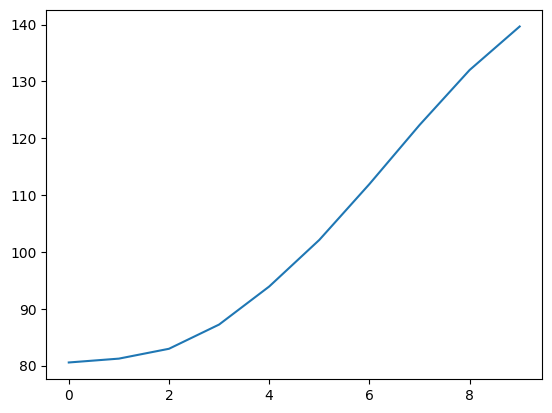

In [19]:
## Plotting the shapelets is easy

plt.plot(torch.tensor(model.shapelets[0]))  ## I'll Try to make it match with the timeseries later 

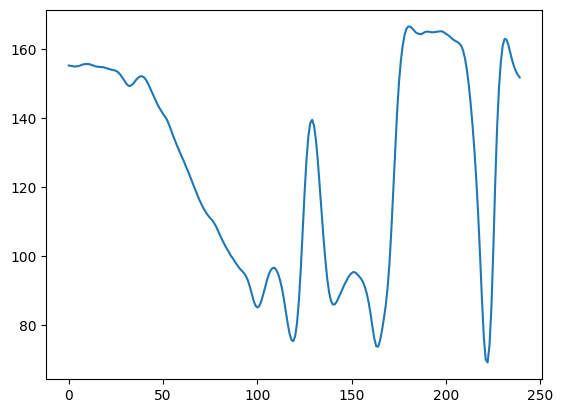

In [46]:
plt.plot(ts_data[0, :])

In [23]:
from utils.DTW import *

tensor(1.2247)


In [28]:
ts1 = torch.tensor([[1.0, 4.5], [2.0, 3.0], [3.0, 4.0]], requires_grad=True)
ts2 = torch.tensor([[1.5, 2.5], [2.5, 3.5], [3.5, 4.5]])

dtw_distance = DTW_calc(ts1, ts2)

# Compute gradients
dtw_distance.backward()

print("DTW Distance:", dtw_distance.item())
print("Gradient for ts1:", ts1.grad)

DTW Distance: 2.291287899017334
Gradient for ts1: tensor([[-0.2182,  0.8729],
        [-0.2182, -0.2182],
        [-0.2182, -0.2182]])
